In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from matplotlib import cm
import librosa
import librosa.display
import random
%matplotlib inline

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = np.load('./drive/MyDrive/data.npy', allow_pickle=True)

In [4]:
data_dict = data.item()

In [5]:
data_dict.keys()

dict_keys(['index', 'audio_features', 'video_features', 'labels'])

In [6]:
audio_features = data_dict['audio_features']
video_features = data_dict['video_features']
labels = data_dict['labels']

In [7]:
print("Audio representation shape:",audio_features.shape)
print("Video representation shape:",video_features.shape)
print("Labels shape:",labels.shape)

Audio representation shape: (1440, 40, 502, 1)
Video representation shape: (1440, 6, 64, 64, 3)
Labels shape: (1440,)


#### Splitting the data based on the actor number

In [8]:
from sklearn.model_selection import train_test_split

N_TRAIN_ACTORS = 17
N_VAL_ACTORS = 5
N_TEST_ACTORS = 2

N_SAMPLES_ACTOR = 60

audio_features_train = np.squeeze(audio_features[0:(N_SAMPLES_ACTOR*N_TRAIN_ACTORS)])
audio_features_val = np.squeeze(audio_features[(N_SAMPLES_ACTOR*N_TRAIN_ACTORS):(N_SAMPLES_ACTOR*(N_VAL_ACTORS+N_TRAIN_ACTORS))])
audio_features_test = np.squeeze(audio_features[(N_SAMPLES_ACTOR*(N_VAL_ACTORS+N_TRAIN_ACTORS)):])


video_features_train = video_features[0:(N_SAMPLES_ACTOR*N_TRAIN_ACTORS)]
video_features_val = video_features[(N_SAMPLES_ACTOR*N_TRAIN_ACTORS):(N_SAMPLES_ACTOR*(N_VAL_ACTORS+N_TRAIN_ACTORS))]
video_features_test = video_features[(N_SAMPLES_ACTOR*(N_VAL_ACTORS+N_TRAIN_ACTORS)):]


labels_train = labels[0:(N_SAMPLES_ACTOR*N_TRAIN_ACTORS)]
labels_val = labels[(N_SAMPLES_ACTOR*N_TRAIN_ACTORS):(N_SAMPLES_ACTOR*(N_VAL_ACTORS+N_TRAIN_ACTORS))]
labels_test = labels[(N_SAMPLES_ACTOR*(N_VAL_ACTORS+N_TRAIN_ACTORS)):]

'''
audio_features_train, audio_features_val, labels_train, labels_val = train_test_split(audio_features, labels, test_size=0.4, random_state=1)
audio_features_val, audio_features_test, labels_val, labels_test = train_test_split(audio_features_val, labels_val, test_size=0.5, random_state=1)
    
video_features_train, video_features_val, labels_train, labels_val = train_test_split(video_features, labels, test_size=0.4, random_state=1)
video_features_val, video_features_test, labels_val, labels_test = train_test_split(video_features_val, labels_val, test_size=0.5, random_state=1)


audio_features_train = np.squeeze(audio_features_train)
audio_features_val = np.squeeze(audio_features_val)
audio_features_test = np.squeeze(audio_features_test)
'''
print(audio_features_train.shape)
print(audio_features_val.shape)
print(audio_features_test.shape)

print(video_features_train.shape)
print(video_features_val.shape)
print(video_features_test.shape)

print(labels_train.shape)
print(labels_val.shape)
print(labels_test.shape)

(864, 40, 502)
(288, 40, 502)
(288, 40, 502)
(864, 6, 64, 64, 3)
(288, 6, 64, 64, 3)
(288, 6, 64, 64, 3)
(864,)
(288,)
(288,)


#### We create a data generator for the image data
In order to return a tuple ([x0, x1], y0) with x0 being the audio and x1 the video, the generator returns the index of the image.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
DESIRED_N_FRAMES = 6

seed = 1

data_gen_args = dict(featurewise_center=False,
                      featurewise_std_normalization=False,
                      rotation_range=0,
                      width_shift_range=0,
                      height_shift_range=0,
                      zoom_range=0,
                      horizontal_flip=False)

datagen = ImageDataGenerator(**data_gen_args)

datagen.fit(np.vstack(video_features_train), augment=True, seed=seed)

datagen = datagen.flow(np.vstack(video_features_train), np.repeat(np.arange(0,len(video_features_train)), DESIRED_N_FRAMES), 
                       batch_size=32, shuffle=True, seed=seed)

In [10]:
def myGenerator(train_generator):
    while True:
        xy = train_generator.next()
        image = xy[0]
        index = xy[1]
        audio = audio_features_train[index]
        label = labels_train[index]
        yield ([audio, image], label, index)

In [11]:
train_generator = myGenerator(datagen)

(32, 64, 64, 3)
(32, 40, 502)
(32,)


<Figure size 432x288 with 0 Axes>

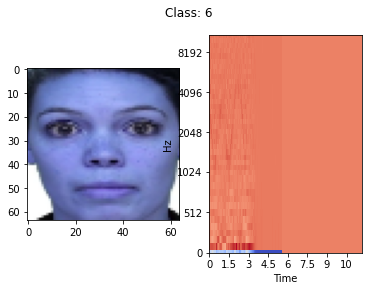

<Figure size 432x288 with 0 Axes>

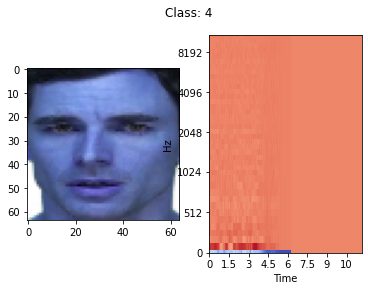

<Figure size 432x288 with 0 Axes>

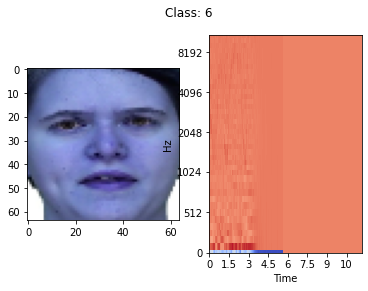

In [12]:
[audio, image], label, _ = next(train_generator)

print(image.shape)
print(audio.shape)
print(label.shape)

n_images = 3

for i in range(n_images):
    plt.figure()
    f, axarr = plt.subplots(1,2)
    r = random.randint(0, len(image)-1)
    
    axarr[0].imshow((image[r] * 255).astype(np.uint8))
    f.suptitle(str("Class: "+str(label[r])))
    #librosa.display.waveplot(data, sr=sampling_rate)
    librosa.display.specshow(np.squeeze(audio[r]), sr=22050, x_axis='time', y_axis='mel')
    #axarr[1].imshow(np.squeeze(audio[r]), interpolation='nearest', cmap=cm.coolwarm, origin='lower')

plt.show()

In [13]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

In [14]:
audio.shape[1:]

(40, 502)

#### First audio model: LSTM

In [15]:
AUDIO_SHAPE = audio.shape[1:3]

def lstm_model(input_size=AUDIO_SHAPE):
    inputs = Input(input_size)
    
    # apply forwards LSTM
    frw_lstm1 = LSTM(64, return_sequences=True)(inputs)
    # apply backwards LSTM
    bck_lstm1 = LSTM(64, return_sequences=True, go_backwards=True)(inputs)

    # concatenate the outputs of the 2 LSTMs
    merged1 = concatenate([frw_lstm1, bck_lstm1], axis=-1)
    merged1 = Dropout(0.5)(merged1)
    
    # apply forwards LSTM
    frw_lstm2 = LSTM(64, return_sequences=True)(merged1)
    # apply backwards LSTM
    bck_lstm2 = LSTM(64, return_sequences=True, go_backwards=True)(merged1)

    # concatenate the outputs of the 2 LSTMs
    merged2 = concatenate([frw_lstm2, bck_lstm2], axis=-1)
    merged2 = Dropout(0.5)(merged2)
    
    # TimeDistributed for sequence
    merged2 = TimeDistributed(Dense(128, activation='relu'))(merged2)
    
    output = GlobalAveragePooling1D()(merged2)

    #model = Model(inputs, output)
    
    return inputs, output

In [16]:
inp, out = lstm_model()
Model(inp, out).summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 502)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 40, 64)       145152      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 40, 64)       145152      input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 40, 128)      0           lstm[0][0]                       
                                                                 lstm_1[0][0]          

#### Second audio model: CNN-based

In [17]:
AUDIO_SHAPE = audio.shape[1:3]

def cnn_model(input_size=AUDIO_SHAPE):
    inputs = Input(input_size)

    conv1 = Conv1D(64, 5, padding='same')(inputs)
    drop1 = Dropout(0.1)(conv1)
    pool1 = MaxPooling1D(pool_size=(8))(drop1)

    conv2 = Conv1D(64, 5, padding='same', activation='relu')(pool1)
    drop2 = Dropout(0.1)(conv2)

    output = Flatten()(drop2)
    
    #model = Model(inputs, output)
    
    return inputs, output

In [18]:
inp, out = cnn_model()
Model(inp, out).summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40, 502)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 40, 64)            160704    
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 64)             20544     
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 320)              

#### First video model: ResNet

In [19]:
# reference: https://gist.github.com/mjdietzx/0cb95922aac14d446a6530f87b3a04ce

IMAGE_SHAPE = image.shape[1:]

img_height = IMAGE_SHAPE[0]
img_width = IMAGE_SHAPE[1]
img_channels = IMAGE_SHAPE[2]

#
# network params
#

cardinality = 32


def resnet_model(video_shape=IMAGE_SHAPE):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = BatchNormalization()(y)
        y = LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:
        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)

        y = add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = LeakyReLU()(y)

        return y

    inputs = Input(shape=(img_height, img_width, img_channels))
    
    # conv1
    conv1 = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
    conv1 = add_common_layers(conv1)

    # conv2
    conv2 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv1)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        conv2 = residual_block(conv2, 128, 256, _project_shortcut=project_shortcut)

    # conv3
    strides = (2, 2)
    conv3 = residual_block(conv2, 256, 512, _strides=strides)
    for i in range(3):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (1, 1)
        conv3 = residual_block(conv3, 256, 512, _strides=strides)

    # conv4
    strides = (2, 2)
    conv4 = residual_block(conv3, 512, 1024, _strides=strides)
    for i in range(5):
        strides = (1, 1)
        conv4 = residual_block(conv4, 512, 1024, _strides=strides)

    # conv5
    strides = (2, 2)
    conv5 = residual_block(conv4, 1024, 2048, _strides=strides)
    for i in range(2):
        strides = (1, 1)
        conv5 = residual_block(conv5, 1024, 2048, _strides=strides)

    conv5 = GlobalAveragePooling2D()(conv5)
    outputs = Dense(128)(conv5)

    #model = Model(inputs, outputs)
    
    return inputs, outputs

In [20]:
inp, out = resnet_model()
Model(inp, out).summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

#### Second video model: VGG

In [21]:
IMAGE_SHAPE = image.shape[1:]

img_height = IMAGE_SHAPE[0]
img_width = IMAGE_SHAPE[1]
img_channels = IMAGE_SHAPE[2]


def vgg_model(video_shape=IMAGE_SHAPE):

    inputs = Input(shape=(img_height, img_width, img_channels))
    
    conv1 = Convolution2D(64, 3, activation='relu', padding = 'same')(inputs)
    conv1 = Convolution2D(64, 3, activation='relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1)
    
    conv2 = Convolution2D(128, 3, activation='relu', padding = 'same')(pool1)
    conv2 = Convolution2D(128, 3, activation='relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2)
    
    conv3 = Convolution2D(256, 3, activation='relu', padding = 'same')(pool2)
    conv3 = Convolution2D(256, 3, activation='relu', padding = 'same')(conv3)
    #conv3 = Convolution2D(256, 3, activation='relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3)

    conv4 = Convolution2D(512, 3, activation='relu', padding = 'same')(pool3)
    #conv4 = Convolution2D(512, 3, activation='relu', padding = 'same')(conv4)
    #conv4 = Convolution2D(512, 3, activation='relu', padding = 'same')(conv4)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4)
    '''
    conv5 = Convolution2D(512, 3, activation='relu', padding = 'same')(pool4)
    conv5 = Convolution2D(512, 3, activation='relu', padding = 'same')(conv5)
    conv5 = Convolution2D(512, 3, activation='relu', padding = 'same')(conv5)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2))(conv5)
    '''
    flat = Flatten()(pool4)
    fc6 = Dense(2048, activation='relu')(flat)
    fc6 = Dropout(0.5)(fc6)
    fc7 = Dense(2048, activation='relu')(fc6)
    fc7 = Dropout(0.5)(fc7)

    outputs = Dense(128)(fc7)

    #model = Model(inputs, outputs)
    
    return inputs, outputs

In [22]:
inp, out = vgg_model()
Model(inp, out).summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_549 (Conv2D)          (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_550 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_551 (Conv2D)          (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_552 (Conv2D)          (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)      

## Test models separately

#### Audio CNN

In [29]:
inp, out = cnn_model()

x = Dense(128, activation='relu')(out)

output = Dense(7, activation='softmax')(x)

model = Model(inputs=inp,outputs=output)
opt = tf.keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 40, 502)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 64)            160704    
_________________________________________________________________
dropout_6 (Dropout)          (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 64)             20544     
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)              

In [30]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [31]:
history = model.fit(audio_features_train, labels_train, batch_size=16, epochs=1000, validation_data=(audio_features_val, labels_val))

Epoch 1/1000
54/54 [==============================] - 1s 10ms/step - loss: 1.9987 - accuracy: 0.1840 - val_loss: 1.8920 - val_accuracy: 0.2118
Epoch 2/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.8958 - accuracy: 0.2431 - val_loss: 1.8858 - val_accuracy: 0.2292
Epoch 3/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.8654 - accuracy: 0.2465 - val_loss: 1.8660 - val_accuracy: 0.2431
Epoch 4/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.8238 - accuracy: 0.2743 - val_loss: 1.8484 - val_accuracy: 0.2569
Epoch 5/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.7989 - accuracy: 0.2905 - val_loss: 1.8180 - val_accuracy: 0.2674
Epoch 6/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.7629 - accuracy: 0.3021 - val_loss: 1.8220 - val_accuracy: 0.2743
Epoch 7/1000
54/54 [==============================] - 0s 7ms/step - loss: 1.7346 - accuracy: 0.3333 - val_loss: 1.7874 - val_accuracy: 0.2986
Epoch

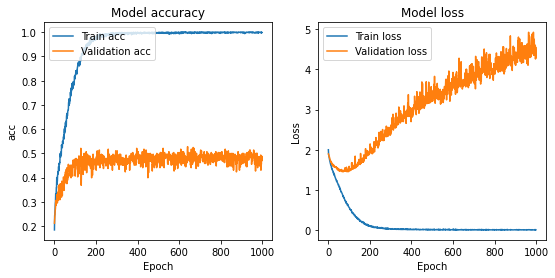

In [32]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train acc', 'Validation acc'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

In [33]:
score = model.evaluate(audio_features_test, labels_test, verbose = 0) 

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 4.297683238983154
Test accuracy: 0.5104166865348816


#### Audio LSTM

In [34]:
inp, out = lstm_model()

x = Dense(128, activation='relu')(out)

output = Dense(7, activation='softmax')(x)

model = Model(inputs=inp,outputs=output)
opt = tf.keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 40, 502)]    0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 40, 64)       145152      input_6[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 40, 64)       145152      input_6[0][0]                    
__________________________________________________________________________________________________
concatenate_18 (Concatenate)    (None, 40, 128)      0           lstm_4[0][0]                     
                                                                 lstm_5[0][0]         

In [35]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [36]:
history = model.fit(audio_features_train, labels_train, batch_size=16, epochs=1000, validation_data=(audio_features_val, labels_val))

Epoch 1/1000
54/54 [==============================] - 4s 77ms/step - loss: 1.9401 - accuracy: 0.1944 - val_loss: 1.9370 - val_accuracy: 0.1771
Epoch 2/1000
54/54 [==============================] - 3s 52ms/step - loss: 1.9300 - accuracy: 0.1991 - val_loss: 1.9296 - val_accuracy: 0.1840
Epoch 3/1000
54/54 [==============================] - 3s 53ms/step - loss: 1.9197 - accuracy: 0.2014 - val_loss: 1.9207 - val_accuracy: 0.1910
Epoch 4/1000
54/54 [==============================] - 3s 53ms/step - loss: 1.9054 - accuracy: 0.2153 - val_loss: 1.9073 - val_accuracy: 0.2083
Epoch 5/1000
54/54 [==============================] - 3s 52ms/step - loss: 1.8886 - accuracy: 0.2269 - val_loss: 1.8965 - val_accuracy: 0.2083
Epoch 6/1000
54/54 [==============================] - 3s 52ms/step - loss: 1.8768 - accuracy: 0.2280 - val_loss: 1.8884 - val_accuracy: 0.2188
Epoch 7/1000
54/54 [==============================] - 3s 51ms/step - loss: 1.8632 - accuracy: 0.2384 - val_loss: 1.8803 - val_accuracy: 0.2604

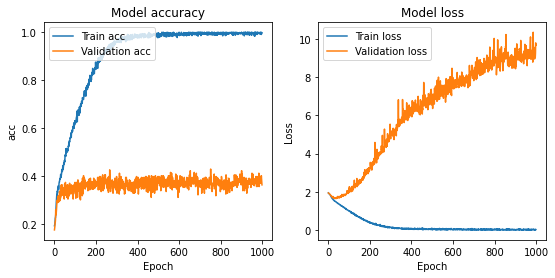

In [37]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train acc', 'Validation acc'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

In [38]:
score = model.evaluate(audio_features_test, labels_test, verbose = 0) 

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 8.538052558898926
Test accuracy: 0.40625


#### Video VGG

In [39]:
inp, out = vgg_model()

x = Dense(128, activation='relu')(out)

output = Dense(7, activation='softmax')(x)

model = Model(inputs=inp,outputs=output)
opt = tf.keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_556 (Conv2D)          (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_557 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_558 (Conv2D)          (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_559 (Conv2D)          (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 128)     

In [40]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [41]:
history = model.fit(np.vstack(video_features_train), np.repeat(labels_train, DESIRED_N_FRAMES), batch_size=16, epochs=100, 
                           validation_data=(np.vstack(video_features_val), np.repeat(labels_val, DESIRED_N_FRAMES)))

Epoch 1/100
324/324 [==============================] - 19s 58ms/step - loss: 1.9355 - accuracy: 0.1975 - val_loss: 1.9389 - val_accuracy: 0.1771
Epoch 2/100
324/324 [==============================] - 19s 58ms/step - loss: 1.8806 - accuracy: 0.2392 - val_loss: 1.8532 - val_accuracy: 0.2037
Epoch 3/100
324/324 [==============================] - 19s 58ms/step - loss: 1.7211 - accuracy: 0.3193 - val_loss: 1.5396 - val_accuracy: 0.4039
Epoch 4/100
324/324 [==============================] - 19s 58ms/step - loss: 1.4370 - accuracy: 0.4323 - val_loss: 1.3646 - val_accuracy: 0.4971
Epoch 5/100
324/324 [==============================] - 19s 58ms/step - loss: 1.2181 - accuracy: 0.5309 - val_loss: 1.1498 - val_accuracy: 0.5706
Epoch 6/100
324/324 [==============================] - 19s 58ms/step - loss: 1.0469 - accuracy: 0.6161 - val_loss: 1.0718 - val_accuracy: 0.6065
Epoch 7/100
324/324 [==============================] - 19s 58ms/step - loss: 0.8929 - accuracy: 0.6779 - val_loss: 0.9949 - val_ac

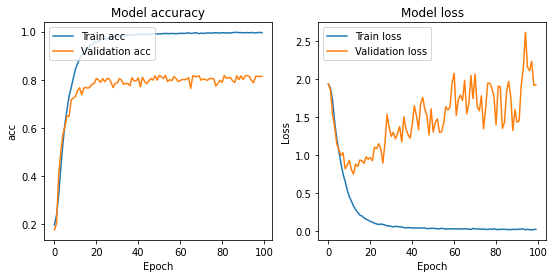

In [42]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train acc', 'Validation acc'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

In [43]:
score = model.evaluate(np.vstack(video_features_test), np.repeat(labels_test, DESIRED_N_FRAMES), verbose = 0) 

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.10910701751709
Test accuracy: 0.8003472089767456


#### Video Resnet

In [44]:
inp, out = resnet_model()

x = Dense(128, activation='relu')(out)

output = Dense(7, activation='softmax')(x)

model = Model(inputs=inp,outputs=output)
opt = tf.keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_563 (Conv2D)             (None, 32, 32, 64)   9472        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 32, 32, 64)   256         conv2d_563[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_49 (LeakyReLU)      (None, 32, 32, 64)   0           batch_normalization_53[0][0]     
______________________________________________________________________________________

In [45]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [46]:
history = model.fit(np.vstack(video_features_train), np.repeat(labels_train, DESIRED_N_FRAMES), batch_size=16, epochs=100, 
                           validation_data=(np.vstack(video_features_val), np.repeat(labels_val, DESIRED_N_FRAMES)))

Epoch 1/100
324/324 [==============================] - 101s 312ms/step - loss: 1.5685 - accuracy: 0.4211 - val_loss: 2.6011 - val_accuracy: 0.1788
Epoch 2/100
324/324 [==============================] - 94s 291ms/step - loss: 0.9765 - accuracy: 0.6497 - val_loss: 1.4648 - val_accuracy: 0.5058
Epoch 3/100
324/324 [==============================] - 94s 290ms/step - loss: 0.6592 - accuracy: 0.7606 - val_loss: 1.4059 - val_accuracy: 0.5584
Epoch 4/100
324/324 [==============================] - 94s 292ms/step - loss: 0.4738 - accuracy: 0.8326 - val_loss: 1.5458 - val_accuracy: 0.5457
Epoch 5/100
324/324 [==============================] - 95s 294ms/step - loss: 0.3727 - accuracy: 0.8673 - val_loss: 2.2410 - val_accuracy: 0.4612
Epoch 6/100
324/324 [==============================] - 95s 294ms/step - loss: 0.3300 - accuracy: 0.8868 - val_loss: 1.4140 - val_accuracy: 0.6238
Epoch 7/100
324/324 [==============================] - 95s 294ms/step - loss: 0.2588 - accuracy: 0.9132 - val_loss: 1.3923 

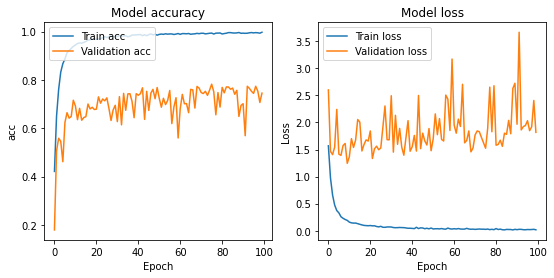

In [47]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train acc', 'Validation acc'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

In [48]:
score = model.evaluate(np.vstack(video_features_test), np.repeat(labels_test, DESIRED_N_FRAMES), verbose = 0) 

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.9566339254379272
Test accuracy: 0.7228009104728699


## Final model

A combination of the CNN-like model and the VGG-like model was used because they performed better than the more complex models separately.

In [49]:
audio_inp, audio_out = cnn_model()
video_inp, video_out = vgg_model()

model_list=[audio_out, video_out]

merged = concatenate(model_list,axis=1)

x = Dense(256, activation='relu')(merged)

output = Dense(7, activation='softmax')(x)

model = Model(inputs=[audio_inp, video_inp],outputs=output)

opt = tf.keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
'''
history = model.fit(x=[np.repeat(audio_features_train, DESIRED_N_FRAMES), np.vstack(video_features_train)], 
                               y=np.repeat(labels_train, DESIRED_N_FRAMES),
                               batch_size=16, epochs=100, 
                           validation_data=([np.repeat(audio_features_val, DESIRED_N_FRAMES), np.vstack(video_features_val)], 
                                            np.repeat(labels_val, DESIRED_N_FRAMES)))
'''
EPOCHS = 100
BS = 16


history = model.fit(train_generator,
                          validation_data=([np.repeat(audio_features_val,DESIRED_N_FRAMES).reshape(audio_features_val.shape[0]*DESIRED_N_FRAMES,audio.shape[1],audio.shape[2]), 
                                                np.vstack(video_features_val)], 
                                               np.repeat(labels_val, DESIRED_N_FRAMES)),
                          steps_per_epoch=len(video_features_train) // BS, epochs=EPOCHS)

Epoch 1/100
54/54 [==============================] - 10s 193ms/step - loss: 1.9546 - accuracy: 0.1937 - val_loss: 1.9412 - val_accuracy: 0.1921
Epoch 2/100
54/54 [==============================] - 10s 190ms/step - loss: 1.9229 - accuracy: 0.2242 - val_loss: 1.9273 - val_accuracy: 0.1892
Epoch 3/100
54/54 [==============================] - 10s 191ms/step - loss: 1.8919 - accuracy: 0.2417 - val_loss: 1.8982 - val_accuracy: 0.1973
Epoch 4/100
54/54 [==============================] - 10s 192ms/step - loss: 1.8370 - accuracy: 0.2739 - val_loss: 1.8554 - val_accuracy: 0.2506
Epoch 5/100
54/54 [==============================] - 10s 192ms/step - loss: 1.7756 - accuracy: 0.3040 - val_loss: 1.7761 - val_accuracy: 0.2731
Epoch 6/100
54/54 [==============================] - 10s 190ms/step - loss: 1.7138 - accuracy: 0.3356 - val_loss: 1.6942 - val_accuracy: 0.3565
Epoch 7/100
54/54 [==============================] - 10s 192ms/step - loss: 1.5931 - accuracy: 0.3966 - val_loss: 1.5071 - val_accuracy:

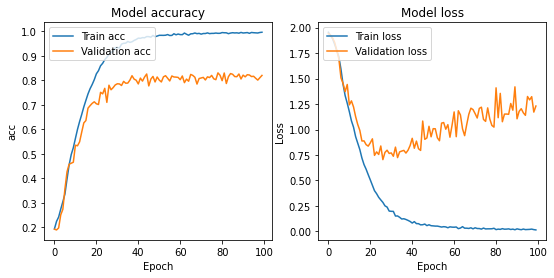

In [50]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train acc', 'Validation acc'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

In [51]:
score = model.evaluate([np.repeat(audio_features_test, DESIRED_N_FRAMES).reshape(audio_features_test.shape[0]*DESIRED_N_FRAMES, audio.shape[1], audio.shape[2]),
                              np.vstack(video_features_test)], np.repeat(labels_test, DESIRED_N_FRAMES), verbose = 0) 

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.473883032798767
Test accuracy: 0.8101851940155029


## Extra optional task: VGGFace2

In [55]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-5o0zzth_
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-5o0zzth_
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=12aa234b45a1530c6023635d408da451ae69790a6499318a5e499bb8f4700b41
  Stored in directory: /tmp/pip-ephem-wheel-cache-kpa9bno_/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [56]:
from keras_vggface.vggface import VGGFace

#### Video-only

In [57]:
#custom parameters
nb_class = 7
hidden_dim = 512

vgg_model = VGGFace(include_top=False, input_shape=(64, 64, 3))
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
model = Model(vgg_model.input, out)

In [58]:
EPOCHS = 20

opt = tf.keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(np.vstack(video_features_train), np.repeat(labels_train, DESIRED_N_FRAMES), batch_size=16, epochs=EPOCHS, 
                           validation_data=(np.vstack(video_features_val), np.repeat(labels_val, DESIRED_N_FRAMES)))

Epoch 1/20
324/324 [==============================] - 27s 83ms/step - loss: 1.3169 - accuracy: 0.5046 - val_loss: 1.0860 - val_accuracy: 0.6470
Epoch 2/20
324/324 [==============================] - 27s 83ms/step - loss: 0.7073 - accuracy: 0.7541 - val_loss: 0.7719 - val_accuracy: 0.7737
Epoch 3/20
324/324 [==============================] - 27s 83ms/step - loss: 0.4384 - accuracy: 0.8492 - val_loss: 0.6821 - val_accuracy: 0.7639
Epoch 4/20
324/324 [==============================] - 27s 83ms/step - loss: 0.3019 - accuracy: 0.8976 - val_loss: 0.6521 - val_accuracy: 0.7795
Epoch 5/20
324/324 [==============================] - 27s 83ms/step - loss: 0.2313 - accuracy: 0.9221 - val_loss: 0.7038 - val_accuracy: 0.7795
Epoch 6/20
324/324 [==============================] - 27s 83ms/step - loss: 0.1829 - accuracy: 0.9338 - val_loss: 1.0689 - val_accuracy: 0.7274
Epoch 7/20
324/324 [==============================] - 27s 83ms/step - loss: 0.1556 - accuracy: 0.9531 - val_loss: 0.5867 - val_accuracy:

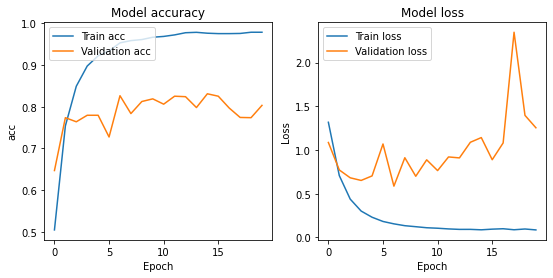

In [59]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train acc', 'Validation acc'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

In [60]:
score = model.evaluate(np.vstack(video_features_test), np.repeat(labels_test, DESIRED_N_FRAMES), verbose = 0) 

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1656935214996338
Test accuracy: 0.8055555820465088


#### Video + audio

In [61]:
#custom parameters
nb_class = 7
hidden_dim = 512

vgg_model = VGGFace(include_top=False, input_shape=(64, 64, 3))
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
video_out = Dense(hidden_dim, activation='relu', name='fc7')(x)

audio_inp, audio_out = cnn_model()

model_list=[audio_out, video_out]

merged = concatenate(model_list,axis=1)

x = Dense(256, activation='relu')(merged)

output = Dense(7, activation='softmax')(x)

model = Model(inputs=[audio_inp, vgg_model.input],outputs=output)

opt = tf.keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

EPOCHS = 20
BS = 32


history = model.fit(x=train_generator,
                          validation_data=([np.repeat(audio_features_val,DESIRED_N_FRAMES).reshape(audio_features_val.shape[0]*DESIRED_N_FRAMES,audio.shape[1],audio.shape[2]), 
                                                np.vstack(video_features_val)], 
                                               np.repeat(labels_val, DESIRED_N_FRAMES)),
                          steps_per_epoch=len(video_features_train) // BS, epochs=EPOCHS)

Epoch 1/20
27/27 [==============================] - 13s 479ms/step - loss: 1.8273 - accuracy: 0.2832 - val_loss: 1.5547 - val_accuracy: 0.3848
Epoch 2/20
27/27 [==============================] - 13s 478ms/step - loss: 1.3984 - accuracy: 0.4851 - val_loss: 1.2496 - val_accuracy: 0.5191
Epoch 3/20
27/27 [==============================] - 13s 477ms/step - loss: 1.1318 - accuracy: 0.5889 - val_loss: 1.1548 - val_accuracy: 0.5851
Epoch 4/20
27/27 [==============================] - 13s 478ms/step - loss: 0.9854 - accuracy: 0.6503 - val_loss: 1.0303 - val_accuracy: 0.6424
Epoch 5/20
27/27 [==============================] - 13s 478ms/step - loss: 0.8205 - accuracy: 0.7085 - val_loss: 1.1603 - val_accuracy: 0.6169
Epoch 6/20
27/27 [==============================] - 13s 478ms/step - loss: 0.6920 - accuracy: 0.7593 - val_loss: 0.9316 - val_accuracy: 0.6852
Epoch 7/20
27/27 [==============================] - 13s 479ms/step - loss: 0.5711 - accuracy: 0.7963 - val_loss: 0.9501 - val_accuracy: 0.7083

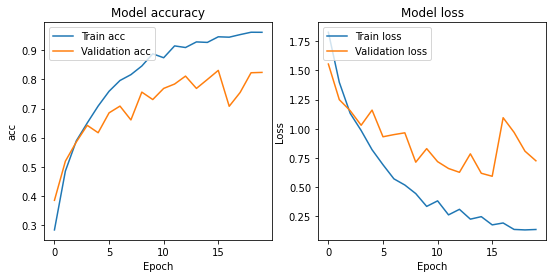

In [62]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train acc', 'Validation acc'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

In [63]:
score = model.evaluate([np.repeat(audio_features_test, DESIRED_N_FRAMES).reshape(audio_features_test.shape[0]*DESIRED_N_FRAMES, audio.shape[1], audio.shape[2]),
                              np.vstack(video_features_test)], np.repeat(labels_test, DESIRED_N_FRAMES), verbose = 0) 

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7199322581291199
Test accuracy: 0.8136574029922485


## Final results:

For this task, the different combinations of models returned the following accuracy:

| Model                           | Test Accuracy      | Test Loss          |
|---------------------------------|--------------------|--------------------|
| CNN-like Audio                  | 0.5104166865348816 | 4.297683238983154  |
| LSTM Audio                      | 0.40625            | 8.538052558898926  |
| VGG-like Video                  | 0.8003472089767456 | 2.10910701751709   |
| ResNet Video                    | 0.7228009104728699 | 1.9566339254379272 |
| VGG-like Video + CNN-like Audio | 0.8101851940155029 | 1.473883032798767  |
| VGGFace2  only Video            | 0.8055555820465088 | 1.1656935214996338 |
| VGGFace2 Video + Audio          | 0.8136574029922485 | 0.7199322581291199 |
